In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets Overview:

### restaurants.csv

[Dataset origin](https://kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus/data
): kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus/data


This sub-dataset includes a total of 11 columns of different information about restaurants on Ubereats. The full column names are:
* id (Restaurant id)
* position (Restaurant position in the search result)
* name (Restaurant name)
* score (Restaurant score)
* ratings (Ratings count)
* category (Restaurant category)
* price_range
* full_address (Restaurant full address)
* zip_code (Zip code)
* lat (Latitude)
* long (Longitude)
* (added) locality : Indicate whether the restaurant serves American cuisine)
* (added) menu_diversity (based on restaurant-menus dataset)



### restaurant-menus.csv
The second sub-dataset is called restaurant-menus.csv, and it contains information about restaurants’menu. There are 5 columns in this sub-dataset:
* restaurant_id (Restaurant id),
* category (Menu category)
* name (Menu Name)
* description (Menu description)
* price (Menu price)




## Research Question: What is the total and direct effect of locality on the restaurant score?


# Show Restaurants Dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

restaurant = pd.read_csv("/content/drive/MyDrive/restaurants.csv")
# import the restaurant data
restaurant.head(2)

,id,position,name,score,ratings,category,price_range,full_address,zip_code,lat,lng
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",$,"224 Daniel Payne Drive, Birmingham, AL, 35207",35207,33.562365,-86.830703
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"Coffee and Tea, Breakfast and Brunch, Bubble Tea",NaN,"1521 Pinson Valley Parkway, Birmingham, AL, 35217",35217,33.583640,-86.773330


# Show restaurant-menus Dataset:

In [3]:
restaurant_menu = pd.read_csv("/content/drive/MyDrive/restaurant-menus.csv")
# import the restaurant data
restaurant_menu.head(2)
# view the dataset

,restaurant_id,category,name,description,price
0,1,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD
1,1,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD


# 1. Dataset Cleaning


In [4]:
unique_price_ranges = restaurant['price_range'].unique()
unique_price_ranges

array(['$', nan, '$$', '$$$', '$$$$', '$$$$$$$$$$$$$$$$$'], dtype=object)

Show that there is only one record with "price range" column to be`$$$$$$$$$$$$$$$$$`

In [5]:
restaurant[restaurant['price_range'] == '$$$$$$$$$$$$$$$$$'].shape

(1, 11)

 We can see that there is only one record with `$$$$$$$$$$$$$$$$$`	price range, and it's clearly unreasonable to have that much `$` sign since the highest level is `$$$$` on uber eats app, and we also remove the records where the price range is undefined (NaN)

In [6]:
valid_price_ranges = ['$', '$$', '$$$', '$$$$']
# normal data range
restaurant_data = restaurant[restaurant['price_range'].isin(valid_price_ranges)]


* To define Menu Diveristy, I went the restaurant-menus dataset, and record how many category each restaurant has. Since the price range is already given, I did not collect the price column values

* Remove the records with empty score


In [7]:
category_counts = restaurant_menu.groupby('restaurant_id')['category'].nunique()
category_counts
data = pd.merge(restaurant_data, category_counts, how='left', left_on='id', right_on='restaurant_id')
#merge the category value into the restaurant table
data.rename(columns={'category_y': 'category'}, inplace=True)
# rename column
data = data.dropna(subset=['score'])
#remove all recoords with empty score column
data.rename(columns={'category_x': 'restaurant_category'}, inplace=True)
# change the restaurant category to avoid duplicated names
data['restaurant_category'] = data['restaurant_category'].astype(str)
# convert all to string type


## Clean restaurant_category column (there are many repeated categories with leading space

In [8]:
omit_type = []
# get all the modified categories
for index, row in data.iterrows():
    categories = row['restaurant_category'].split(',')
    cleaned_categories = []
    # List to hold cleaned categories

    for cat in categories:
        omit_type.append(cat)
        clean_cat = cat.lstrip().lower()
        # Remove leading spaces
        clean_cat.lower()
        cleaned_categories.append(clean_cat)
        # Append cleaned category to list

    #join the cleaned categories back into a single string and update the DataFrame
    data.loc[index, 'restaurant_category'] = ','.join(cleaned_categories)

In [9]:
kept_categories =[]
for index, row in data.iterrows():
    categories = row['restaurant_category'].split(',')
    for cat in categories:
        kept_categories.append(cat)

len(set(kept_categories))

317

### After cleaning (removing empty space and uniform the cases), there is a total of 317 categories

## Based conclude the category into broader category

In [10]:
cuisine_nation_dict = {
    "American": ["American (Traditional)", "Creole", "Southern", "New American", "BBQ", "Cajun", "Tex Mex", "American", "Traditional American", "Hot Dog", "Barbeque", "Southern", "Fried Chicken", "Chicken Wings", "Fast Food", "Burgers", "Chicken", "Soul Food", "Cajun / Creole"],
    "Japanese": ["Japanese sweets", "Japanese set items", "Japanese Skewer food", "Japanese: Sushi", "Ramen", "Japanese: Ramen", "Japanese Style curry", "Japanese BBQ", "Sushi Bar", "Sushi", "Teppanyaki","Tempura"],
    "Chinese": ["Chinese: Other", "Dim Sum", "Chinese", "Chinese: Sichuan", "Chinese: Noodles & Dumplings", "Chinese: Cantonese", "Cantonese", "Chinese Food", "Dumpling House", "Chinese: Cantonese"],
    "Thai": ["Thai", "Northern Thai", "Som Tum", "Tom Yum", "Southern Thai","Southern Thai (due to its unique blend)"],
    "French": ["Modern French", "French tacos", "French"],
    "Indian": ["Thali", "Indian", "Indian Curry", "North Indian", "South Indian", "Biryani"],
    "Italian": ["pizza", "Pizza", "Italian", "Authentic Italian", "Pasta", "italian"],
    "Mexican": ["Mexican", "Tacos", "Quesadillas", "Tex Mex","New Mexican"],
    "British": ["Fish and Chips", "Scottish", "British"],
    "German": ["German"],
    "Turkish": ["Turkish", "Kebab"],
    "Spanish": ["Spanish", "Tapas"],
    "Korean": ["Korean"],
    "Vietnamese": ["Vietnamese", "Pho"],
    "Middle Eastern": ["Jewish", "Persian", "Arabian", "Middle Eastern", "Syrian", "Lebanese"],
    "African": ["African", "Ethiopian", "African: Ethiopian", "Moroccan", "Nigerian", "West African", "South African"],
    "Caribbean": ["Jamaican", "Caribbean", "Puerto Rican"],
    "South American": ["Argentinian", "Peruvian", "Venezuelan", "Brazilian", "Colombian", "Bolivian"],
    "Asian": ["Asian", "South Asian", "Southeast Asian", "Eastern European (some countries in this region are considered part of Asia)", "Asian Fusion", "Asian Cuisine", "Taiwanese", "Singaporean", "Indonesian", "Asian-owned", "Asian: Other", "Mongolian", "Filipino", "Laotian", "Nepalese"],
    "European": ["Modern European", "European", "East European", "Northern European (not explicitly listed but covers countries like Sweden, Norway)", "Balkan", "Danish", "Swedish", "Norwegian", "Finnish", "Polish", "Hungarian", "Czech", "Russian", "Portuguese", "Belgian", "Austrian", "Swiss","Gyro"],
    "Australian": ["Australian", "Aus Burger"]
}

cuisine_nation_lower = {k.lower(): [x.lower() for x in v] for k, v in cuisine_nation_dict.items()}

dict = {}
for cuisine, categories in cuisine_nation_lower.items():
    for category in categories:
        dict[category] = cuisine
#set up dictionary for encoding

# transform all category into nationality

In [11]:
data['nationality'] = 'noset'
# Set default nationality
data['restaurant_category'] = data['restaurant_category'].astype(str)
# change to string type

for index, row in data.iterrows():
    categories = row['restaurant_category'].split(',')
    for cat in categories:
        if cat in dict:
            data.loc[index, 'nationality'] = dict[cat]
            # update to dictionary value

# transform price_range variable

In [12]:
data = data[data['nationality']!="noset"]
label_encoder = LabelEncoder()
data['price_range'] = label_encoder.fit_transform(data['price_range']) + 1
# start price_range at 1

<ipython-input-12-63e8d5e5c889>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_range'] = label_encoder.fit_transform(data['price_range']) + 1


# add local column

In [13]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
# import necessary packages

data['full_score'] = 50

data['local'] = (data['nationality'] == 'american').astype(int)
# add a column further nationality
data['score'] = (data['score'] * 10).astype(int)
# change to integer, multiply by 10
data['score_new'] = 0
# convert score and full_score column to integer type
data['score'] = data['score']*data['ratings'].astype(int)
data['full_score']  = data['full_score']*data['ratings'].astype(int)

data.head()

,id,position,name,score,ratings,restaurant_category,price_range,full_address,zip_code,lat,lng,category,nationality,full_score,local,score_new
4,7,27,Jinsei Sushi,2961,63.0,"sushi,asian,japanese",1,"1830 29th Ave S, Birmingham, AL, 35209",35209,33.480440,-86.790440,7.0,asian,3150,0,0
10,14,51,Panera (521 Fieldstown Road),2024,44.0,"breakfast and brunch,salad,sandwich,family mea...",1,"521 Fieldstown Road, Gardendale, AL, 35071",35071,33.651407,-86.819247,13.0,american,2200,1,0
13,19,30,Falafel Cafe,2352,48.0,"middle eastern,mediterranean,vegetarian,greek,...",1,"401 19th St S, Birmingham, AL, 35233",35233,33.508353,-86.803170,4.0,middle eastern,2400,0,0
14,20,40,MrBeast Burger (838 Odum Road),703,19.0,"american,burgers,sandwich",2,"838 Odum Road, Gardendale, AL, 35071",35071,33.645480,-86.826260,8.0,american,950,1,0
18,27,113,Ruscelli's Food Truck at Mojo Pub,4700,100.0,"italian,exclusive to eats",1,"2801 7th Ave S, Birmingham, AL, 35233",35233,33.511130,-86.788388,13.0,italian,5000,0,0


## Data Cleaning Section （ended)

# DAG

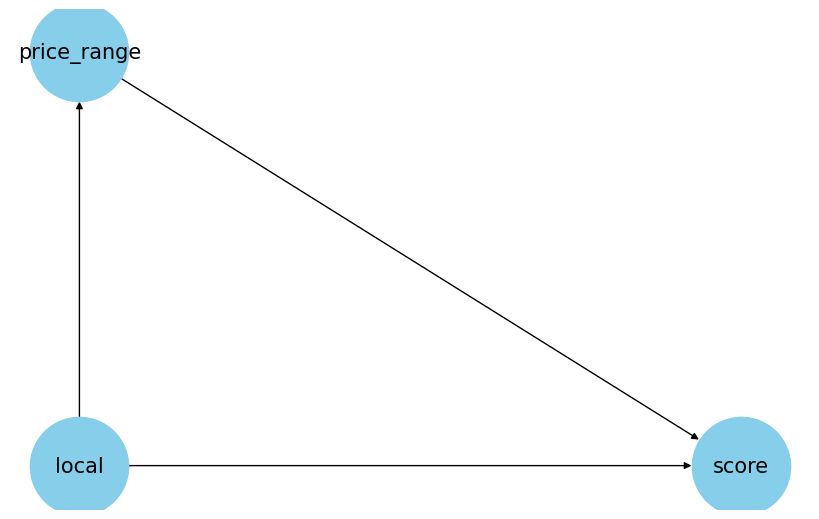

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

#directed graph
G = nx.DiGraph()

edges = [('price_range', 'score'), ('local', 'score'), ('local', 'price_range')]
G.add_edges_from(edges)

# design position for each value
pos = {
    'local': (1, 0),  # X, Y coordinates
    'price_range': (1, 1),
    'score': (2, 0)
}
#draw DAG
plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=5000, edge_color='k', linewidths=1, font_size=15)

# show the plot
plt.show()

# Casual Model

### Restaurant Score = $\beta$0 + $\beta$1* local + $\beta2$ * price_range + $σ$ (error)




### 1. Priors

### Distribution of local, score, and price_range

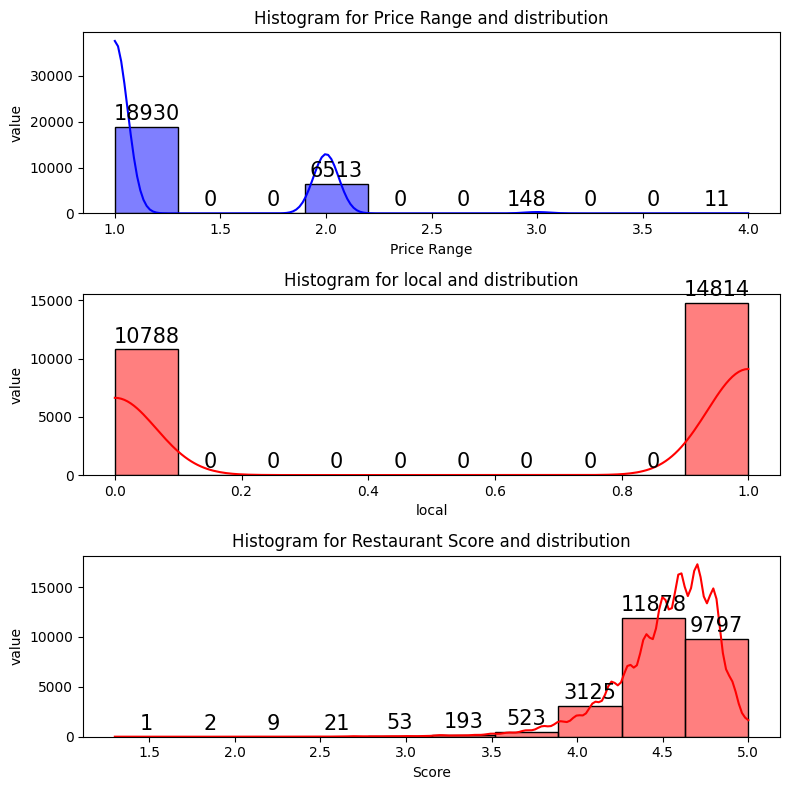

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def alpha_to_probability(alpha):
    return 1 / (1 + np.exp(-alpha))
# helper function to convert from alpha value to probability (for later analysis)
def standardize(series):
    return (series - series.mean()) / series.std()
# helper function to standardize the data

#define figure size and subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# plot price range vairable in histogram and show distribution
hist_data = sns.histplot(data['price_range'], bins=10, color='blue', kde=True, ax=axs[0])
axs[0].set_title('Histogram for Price Range and distribution')
axs[0].set_xlabel('Price Range')
axs[0].set_ylabel('value')

# repeat for `local` and score out of 5
for p in hist_data.patches:
    axs[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', fontsize=15, xytext=(0, 5),
                     textcoords='offset points')


hist_data = sns.histplot(data['local'], bins=10, color='red', kde=True, ax=axs[1])
axs[1].set_title('Histogram for local and distribution')
axs[1].set_xlabel('local')
axs[1].set_ylabel('value')

for p in hist_data.patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', fontsize=15, xytext=(0, 5),
                     textcoords='offset points')


hist_data = sns.histplot(data['score']/data['full_score']*5, bins=10, color='red', kde=True, ax=axs[2])
axs[2].set_title('Histogram for Restaurant Score and distribution')
axs[2].set_xlabel('Score')
axs[2].set_ylabel('value')

for p in hist_data.patches:
    axs[2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', fontsize=15, xytext=(0, 5),
                     textcoords='offset points')


plt.tight_layout()

plt.show()

# Prior Predicative Simulation (local on restaurant score)

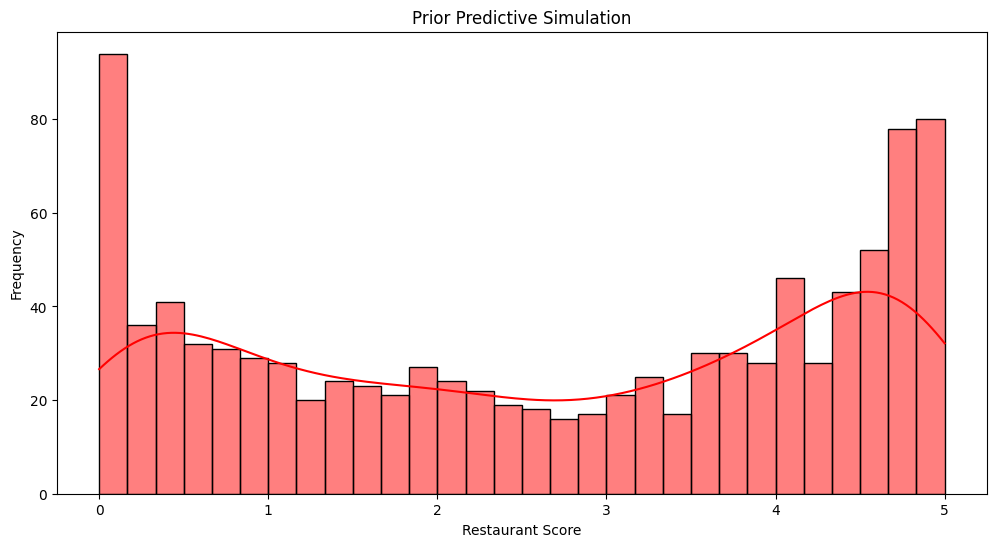

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_transform(y):
    return np.log(y / (5 - y))
    # transform outcome variabel to a 0-5 range

def inverse_logistic_transform(y_prime):
    return 5 * np.exp(y_prime) / (1 + np.exp(y_prime))
    # inverse transformation (0-5) range

n = 1000
#number of points to draw

beta_0_prior_mean = 0
beta_0_prior_sd = 1

beta_1_prior_mean = 0
beta_1_prior_sd = 1

beta_z_prior_mean = 0
beta_z_prior_sd = 1.5
# a slightly higher sd because we can see from previous plot that price_range variable heavily skewed to lower half of values
# define mean and sd

#get coefficent from deisgned priors
beta_0_samples = np.random.normal(beta_0_prior_mean, beta_0_prior_sd, size=n)
beta_1_samples = np.random.normal(beta_1_prior_mean, beta_1_prior_sd, size=n)
beta_z_samples = np.random.normal(beta_z_prior_mean, beta_z_prior_sd, size=n)

#locality variable probability set 0.5 (half and half)
X = np.random.binomial(1, 0.5, n)

#the probability is by viewing the distribution of the price range data
Z = np.random.choice([1, 2, 3, 4], size=n, p=[0.70, 0.285, 0.01, 0.005])

# define error
errors = np.random.normal(0, 1, n)





#create outcome variable
Y = inverse_logistic_transform(beta_0_samples + beta_1_samples * X + beta_z_samples * Z + errors)



# Visualization of the results using both histogram and KDE
plt.figure(figsize=(12, 6))
sns.histplot(Y, bins=30, kde=True, color='red')
plt.title('Prior Predictive Simulation')
plt.xlabel('Restaurant Score')
plt.ylabel('Frequency')
plt.show()


# Posterior Model Analysis

### Total Effect of locality on Restaurant Score

In [17]:
S = data.score.values # response variable
F = data.full_score.values # out of 50
L = data.local.values
P = data.price_range.values-1

with pm.Model() as model_L:
 alpha = pm.Normal("alpha", 0, 1, shape=2)
 # mean of 0 and standard deviation of 1
 p = pm.Deterministic("p", pm.math.invlogit(alpha[L]))
 # get logistic
 mod_S = pm.Binomial("S", F, p, observed=S)
 # get binary outcome from binomial

 idata_L = pm.sample(5000,tune=5000, target_accept=0.95)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


# Get Summary

In [18]:
import arviz as az

az.summary(idata_L, var_names="~p", kind="all")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.494,0.001,2.493,2.495,0.0,0.0,13309.0,11206.0,1.0
alpha[1],2.287,0.000,2.286,2.288,0.0,0.0,12864.0,10922.0,1.0


From above statistics, we can see that the non-local cuisine hasa slightly advantage than the American cuisine. (A higher mean). Furthermore, we can see that both estimates have very small standard deviation and very narrow highest density interval, which means that the parameter estiamtes are precise and consistent thorughtout the posterior samples.
Lastly, r_hat value of 1.0 means that convergence is achieved

In [19]:
(alpha_to_probability(az.summary(idata_L, var_names="~p", kind="all")['mean'][0])*5)-alpha_to_probability(az.summary(idata_L, var_names="~p", kind="all")['mean'][1])*5

0.07962739644215144

## Visualization

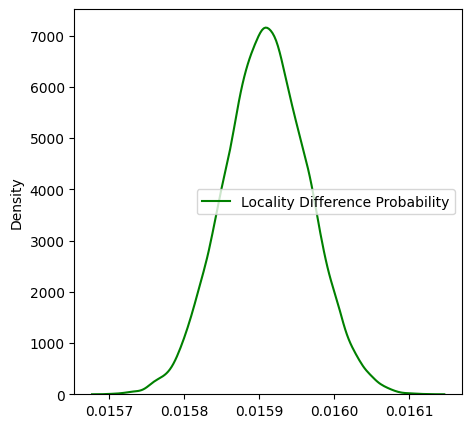

In [20]:
import seaborn as sns
from scipy.special import expit as logistic
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
sns.kdeplot(logistic(az.extract(idata_L).alpha[0])-logistic(az.extract(idata_L).alpha[1]),label ='Locality Difference Probability',color = "green")
#see the probability difference
plt.legend()
plt.show()

# Stratified by Price Range to see the direct effect


In [21]:
with pm.Model() as m_lp_counterfactual:
 d_L = pm.MutableData("locality", L.astype("int64"))
 d_P = pm.MutableData("price_range", P.astype("int64"))
 d_F = pm.MutableData("num", F.astype("int64"))

 alpha = pm.Normal("alpha", 0, 1.5, shape=(2, len(np.unique(P))))
 # higher sd for price_range skewed distribution
 p = pm.Deterministic("p", pm.math.invlogit(alpha[d_L, d_P]))
 mod_S = pm.Binomial("S", d_F, p, observed=S, shape=d_P.shape[0])

 idata_lp_counterfactual = pm.sample()

## Get Summary

In [22]:
import arviz as az

# summary
az.summary(idata_lp_counterfactual, var_names="~p", kind="all")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",2.481,0.001,2.479,2.482,0.000,0.000,6261.0,3671.0,1.0
"alpha[0, 1]",2.526,0.001,2.524,2.528,0.000,0.000,5704.0,3209.0,1.0
"alpha[0, 2]",2.639,0.008,2.623,2.654,0.000,0.000,5952.0,3265.0,1.0
"alpha[0, 3]",2.303,0.023,2.262,2.350,0.000,0.000,5129.0,3059.0,1.0
"alpha[1, 0]",2.323,0.001,2.322,2.324,0.000,0.000,5705.0,3257.0,1.0
"alpha[1, 1]",2.172,0.001,2.171,2.174,0.000,0.000,4909.0,3416.0,1.0
"alpha[1, 2]",2.427,0.007,2.414,2.440,0.000,0.000,5551.0,2952.0,1.0
"alpha[1, 3]",2.426,0.052,2.322,2.520,0.001,0.001,5210.0,3017.0,1.0


# How would the locality affect the score in different price range?

In [23]:
alpha_values = az.extract(idata_lp_counterfactual).alpha

#Calculate probabilities for different cuisine type and price ranges
probS_L0 = logistic(alpha_values[0, 0])
probS_L1 = logistic(alpha_values[1, 0])
probS_L00 = logistic(alpha_values[0, 1])
probS_L11 = logistic(alpha_values[1, 1])

probS_L000 = logistic(alpha_values[0, 2])
probS_L111 = logistic(alpha_values[1, 2])
probS_L0000 = logistic(alpha_values[0, 3])
probS_L1111 = logistic(alpha_values[1, 3])

# Calculate differences
diff_prob_price1 = probS_L0 - probS_L1
diff_prob_price2 = probS_L00 - probS_L11
diff_prob_price3 = probS_L000 - probS_L111
diff_prob_price4 = probS_L0000 - probS_L1111


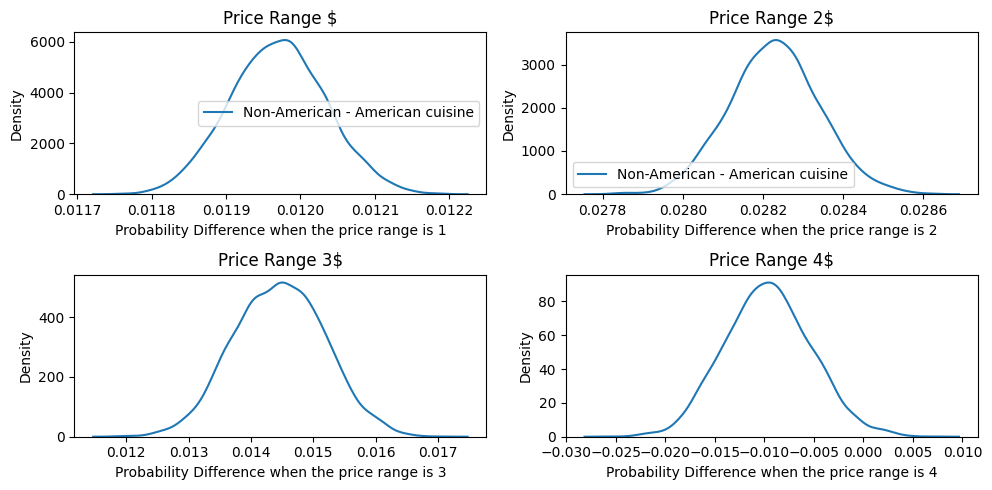

In [24]:
# set figure size
plt.figure(figsize=(10, 5))

# Plot for price range $1
plt.subplot(2, 2, 1)
sns.kdeplot(diff_prob_price1, label='Non-American - American cuisine')
plt.xlabel("Probability Difference when the price range is 1")
plt.title("Price Range $")
plt.legend()

# Plot for price range $2
plt.subplot(2, 2, 2)
sns.kdeplot(diff_prob_price2, label='Non-American - American cuisine')
plt.xlabel("Probability Difference when the price range is 2")
plt.title("Price Range 2$")
plt.legend()

plt.subplot(2, 2, 3)
sns.kdeplot(diff_prob_price3, label='Non-American - American cuisine')
plt.xlabel("Probability Difference when the price range is 3")
plt.title("Price Range 3$")

plt.subplot(2, 2, 4)
sns.kdeplot(diff_prob_price4, label='Non-American - American cuisine')
plt.xlabel("Probability Difference when the price range is 4")
plt.title("Price Range 4$")


plt.tight_layout()
# to keep each subplot in its place
plt.show()


## Reflection from above plots:

From above we can see that non-American cuisnie have advantages in price range from 0 to 2 (`$` - `$$$`). However, the trend changes when the price range is the highest.


# Scaling full_score and Score variable

In [25]:
data['score'] = np.round(data['score'] / 100).astype(int)
data['full_score'] = np.round(data['full_score'] / 100).astype(int)
# if not scalling, the trial number would be too large

score_total = data.full_score.sum()
score_p_r = data.groupby("price_range")["full_score"].sum()

# Posterior Simulation

In [26]:
# simulate the case where all restaurant serve American cuisine
with m_lp_counterfactual:
 pm.set_data(
 {
 "price_range": np.repeat(range(len(score_p_r)), score_p_r),
 "num": np.repeat(1, score_total),
 "locality": np.repeat(1, score_total)
 }
 )
 cf_S_L1 = pm.sample_posterior_predictive(idata_lp_counterfactual)

with m_lp_counterfactual:
 # simulate as if all restaurant serve other types of cuisine
 pm.set_data(
 {
 "price_range": np.repeat(range(len(score_p_r)), score_p_r),
 "num": np.repeat(1, score_total),
 "locality": np.repeat(0, score_total)
 }
 )
 cf_S_L0 = pm.sample_posterior_predictive(idata_lp_counterfactual)

# Separate data based on price range and local columns

In [27]:
data_1_0 = data[(data['price_range'] == 1) & (data['local'] == 0)]
data_1_1 = data[(data['price_range'] == 1) & (data['local'] == 1)]
data_2_0 = data[(data['price_range'] == 2) & (data['local'] == 0)]
data_2_1 = data[(data['price_range'] == 2) & (data['local'] == 1)]
data_3_0 = data[(data['price_range'] == 3) & (data['local'] == 0)]
data_3_1 = data[(data['price_range'] == 3) & (data['local'] == 1)]
data_4_0 = data[(data['price_range'] == 4) & (data['local'] == 0)]
data_4_1 = data[(data['price_range'] == 4) & (data['local'] == 1)]

# Comparing Posterior Distribution

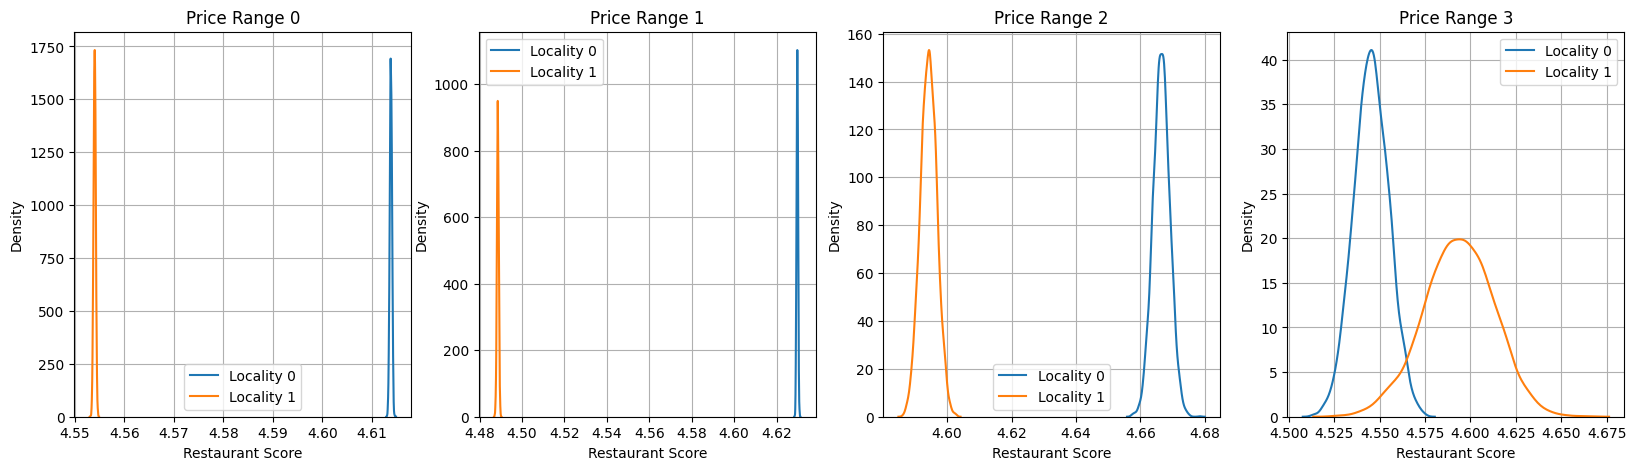

In [28]:
import seaborn as sns

alpha_trace = idata_lp_counterfactual.posterior['alpha'].values

num_price_ranges = 4
#range from 0, 1, 2, or 3

# create figure for the subplots
fig, axes = plt.subplots(1, num_price_ranges, figsize=(20, 5))

# go through each price range
for price_range_index in range(num_price_ranges):
    ax = axes[price_range_index]
    # go through each locality
    for locality_index in range(2):
        specific_combination_trace = alpha_trace[:, :, locality_index, price_range_index].flatten()
        ## extract alpha values
        sns.kdeplot(alpha_to_probability(specific_combination_trace)*5, ax=ax, label=f'Locality {locality_index}')
        # transform to probability and then multiply by 5 o get the restaurant score

    ax.set_title(f'Price Range {price_range_index}')
    ax.set_xlabel('Restaurant Score')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)


# adjust each plot accordingly
plt.show()

# Comparing to Observed Data

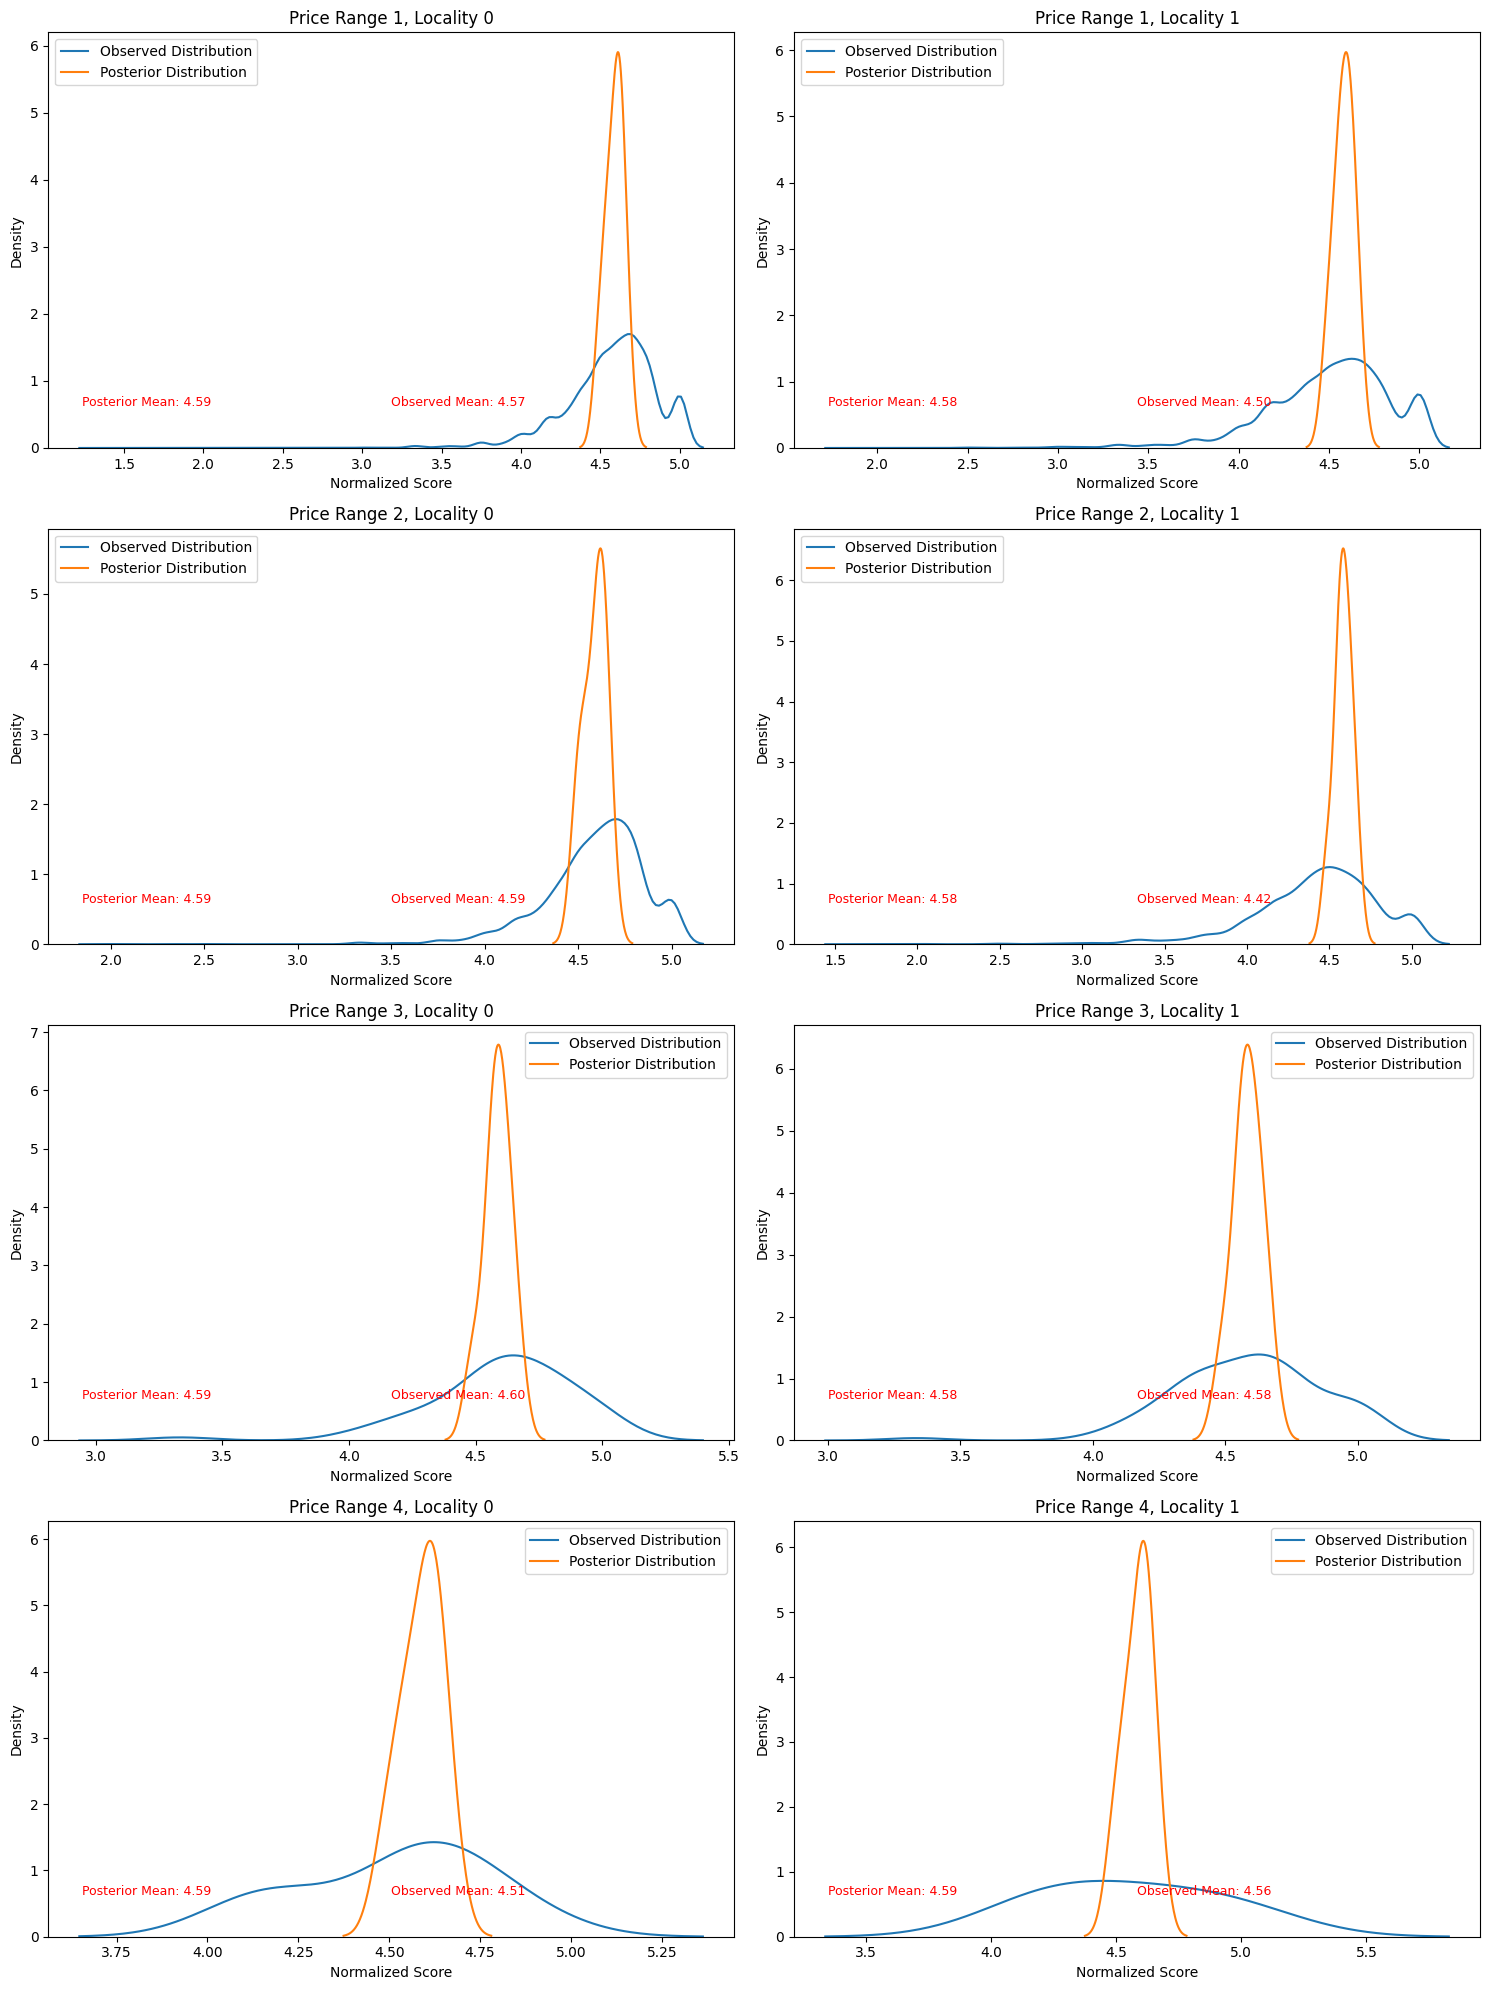

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 20))


#helper function to calcualte and list out the mean
def annotate_mean(ax, data, label, x_offset=0.5, y_offset=0.9):
    mean_val = np.mean(data)
    #position text relative to the axes' limits
    y_limit = ax.get_ylim()
    y_text = y_limit[1] - (y_limit[1] - y_limit[0]) * y_offset
    x_limit = ax.get_xlim()
    x_text = x_limit[0] + (x_limit[1] - x_limit[0]) * x_offset
    #get x,y limits and calcualte the position for text
    ax.text(x_text, y_text, f'{label} Mean: {mean_val:.2f}', fontsize=9, color='red')
    #round to 2

# Loop over data and subplot indices
for i, (data, locality) in enumerate(zip([data_1_0, data_1_1, data_2_0, data_2_1, data_3_0, data_3_1, data_4_0, data_4_1],
                                        ['0', '1', '0', '1', '0', '1', '0', '1'])):
    plt.subplot(4, 2, i+1)
    observed_data = data['score'].values/data['full_score'].values*5
    posterior_data = alpha_to_probability(alpha_trace[int(locality), i // 2].flatten())*5
    #get observed data and posterior samples
    sns.kdeplot(observed_data, label='Observed Distribution')
    sns.kdeplot(posterior_data, label='Posterior Distribution')
    #plot accordingly

    plt.title(f'Price Range {i // 2 + 1}, Locality {locality}')
    plt.xlabel('Normalized Score')
    plt.ylabel('Density')
    plt.legend()

    ax = plt.gca()
    # Get axis

    annotate_mean(ax, observed_data, 'Observed')
    annotate_mean(ax, posterior_data, 'Posterior', x_offset=0.05)
    #add means

plt.tight_layout()
#avoid overlap
plt.show()


## Model representation

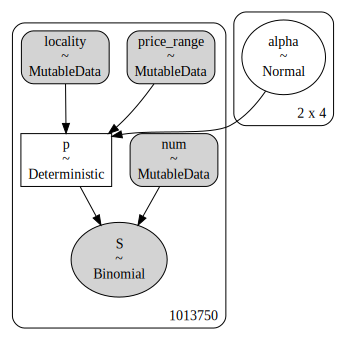

In [30]:
pm.model_to_graphviz(m_lp_counterfactual)

# Extract Posterior Predictive samples

In [31]:
score_L0 = az.extract(cf_S_L0, group="posterior_predictive")
score_L1 = az.extract(cf_S_L1, group="posterior_predictive")
# compute score rate
full = score_L0.S.values.shape[1]
score_rate_l0 = score_L0.S.values.sum(1) / full
admit_rate_l1 = score_L1.S.values.sum(1) / full

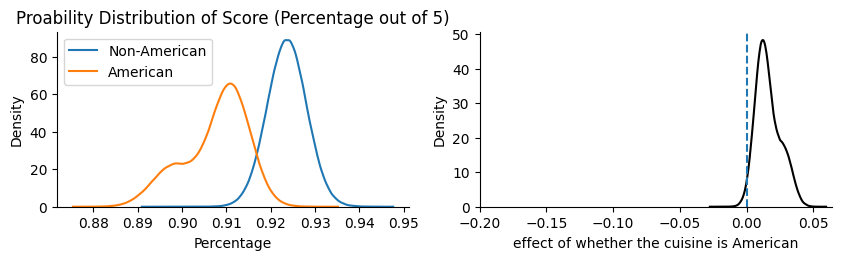

In [32]:
plt.figure(figsize=(10, 5))
#define figure size

# Plot for both types of restaurant
plt.subplot(2, 2, 1)
sns.kdeplot(score_rate_l0, label = 'Non-American')
sns.kdeplot(admit_rate_l1, label = 'American')
plt.xlabel("Percentage")
plt.title("Proability Distribution of Score (Percentage out of 5)")
plt.legend()

# Plot to see the proabbility difference
plt.subplot(2, 2, 2)
sns.kdeplot(score_rate_l0 - admit_rate_l1, color="black")
plt.xlabel("effect of whether the cuisine is American")
plt.xlim(left=-0.2)
plt.axvline(0, linestyle="--")
sns.despine();

# We can we conclude:

From above analysis and plots, we can see that for restaurant that serve other type of cuisines, they would tend to have a slightly higher resturant score on UberEats App comparing to the restaurants that mainly serves American cuisine. However, when we take price range variable into consideration, we can see that on the highest price range on UberEats, the restaurants that mainly serve American cuisine have a higher mean distribution.